#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [1]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git  # clone repo
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15679, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 15679 (delta 1), reused 2 (delta 0), pack-reused 15672
Receiving objects: 100% (15679/15679), 14.45 MiB | 30.20 MiB/s, done.
Resolving deltas: 100% (10746/10746), done.
/content/yolov5


In [2]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
# from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.5/585.5 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 24.2 MB/s eta 0:00:00
Setup complete. Using torch 2.0.0+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


# Your Custom Data

In [3]:
%cd /content 
!unzip 'Sign_language_data.zip'

/content
Archive:  Sign_language_data.zip
  inflating: Sign_language_data/data.yaml  
   creating: Sign_language_data/test/
   creating: Sign_language_data/test/images/
  inflating: Sign_language_data/test/images/Hello.f2021ecd-e018-11ed-9d45-b07b253c2a28.jpg  
  inflating: Sign_language_data/test/images/Hello.f33811d6-e018-11ed-b0d5-b07b253c2a28.jpg  
  inflating: Sign_language_data/test/images/Hello.f46d72d9-e018-11ed-bb1b-b07b253c2a28.jpg  
  inflating: Sign_language_data/test/images/Hello.f80f21ce-e018-11ed-b3a2-b07b253c2a28.jpg  
  inflating: Sign_language_data/test/images/Hello.f9456d7a-e018-11ed-a4e7-b07b253c2a28.jpg  
  inflating: Sign_language_data/test/images/Hello.fa7b6ccf-e018-11ed-882b-b07b253c2a28.jpg  
  inflating: Sign_language_data/test/images/Hello.fbb11b80-e018-11ed-94bf-b07b253c2a28.jpg  
  inflating: Sign_language_data/test/images/Hello.fce767ba-e018-11ed-9352-b07b253c2a28.jpg  
  inflating: Sign_language_data/test/images/Hello.fe1e4f64-e018-11ed-8bdb-b07b253c2a28.

In [4]:
# this is the YAML file  we're loading into this notebook with our data
%cat '/content/data.yaml'

train: ../train/images
val: ../test/images

nc: 13
names: ['Hello','How','I_Love_You','No','Please','Sorry','Thank_You','What','When','Where','Which','Yes','You_Are_Welcome']


# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [5]:
# define number of classes based on YAML
import yaml
with open("/content/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [6]:
num_classes

'13'

In [7]:
#this is the model configuration we will use 
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]

In [8]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [9]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [10]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py  --patience 0 --img 416 --batch 16 --epochs 250 --data '/content/data.yaml' --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results  --cache

/content/yolov5
train: weights=yolov5s.pt, cfg=./models/custom_yolov5s.yaml, data=/content/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=250, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=0, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-168-gec2b853 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, an

# Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

In [12]:
!nvidia-smi

Wed May 17 11:11:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

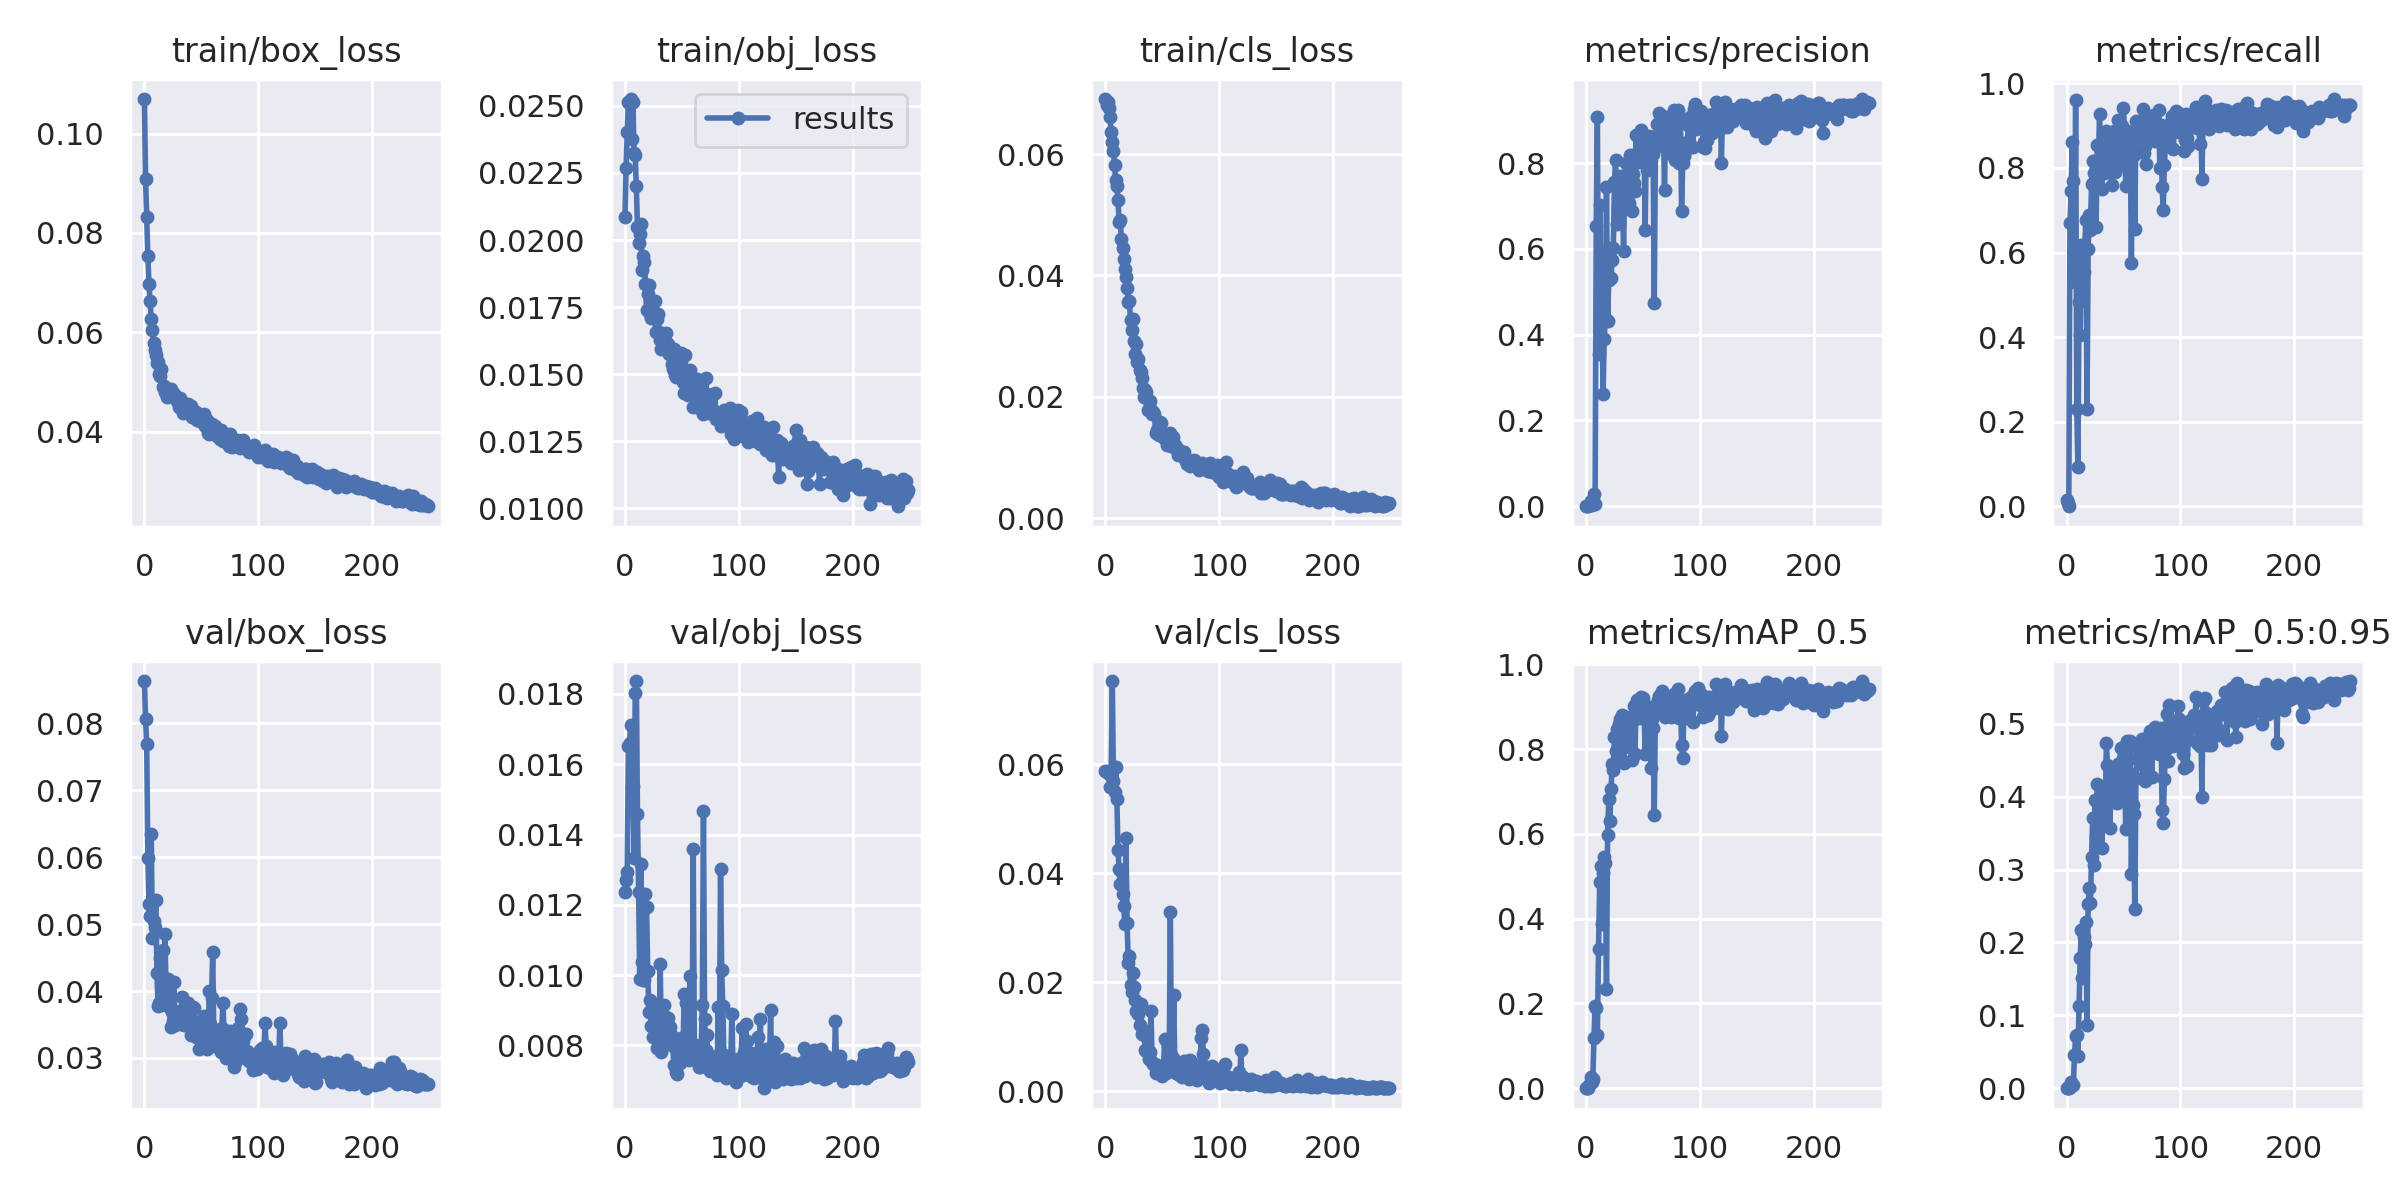

In [13]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

GROUND TRUTH TRAINING DATA:


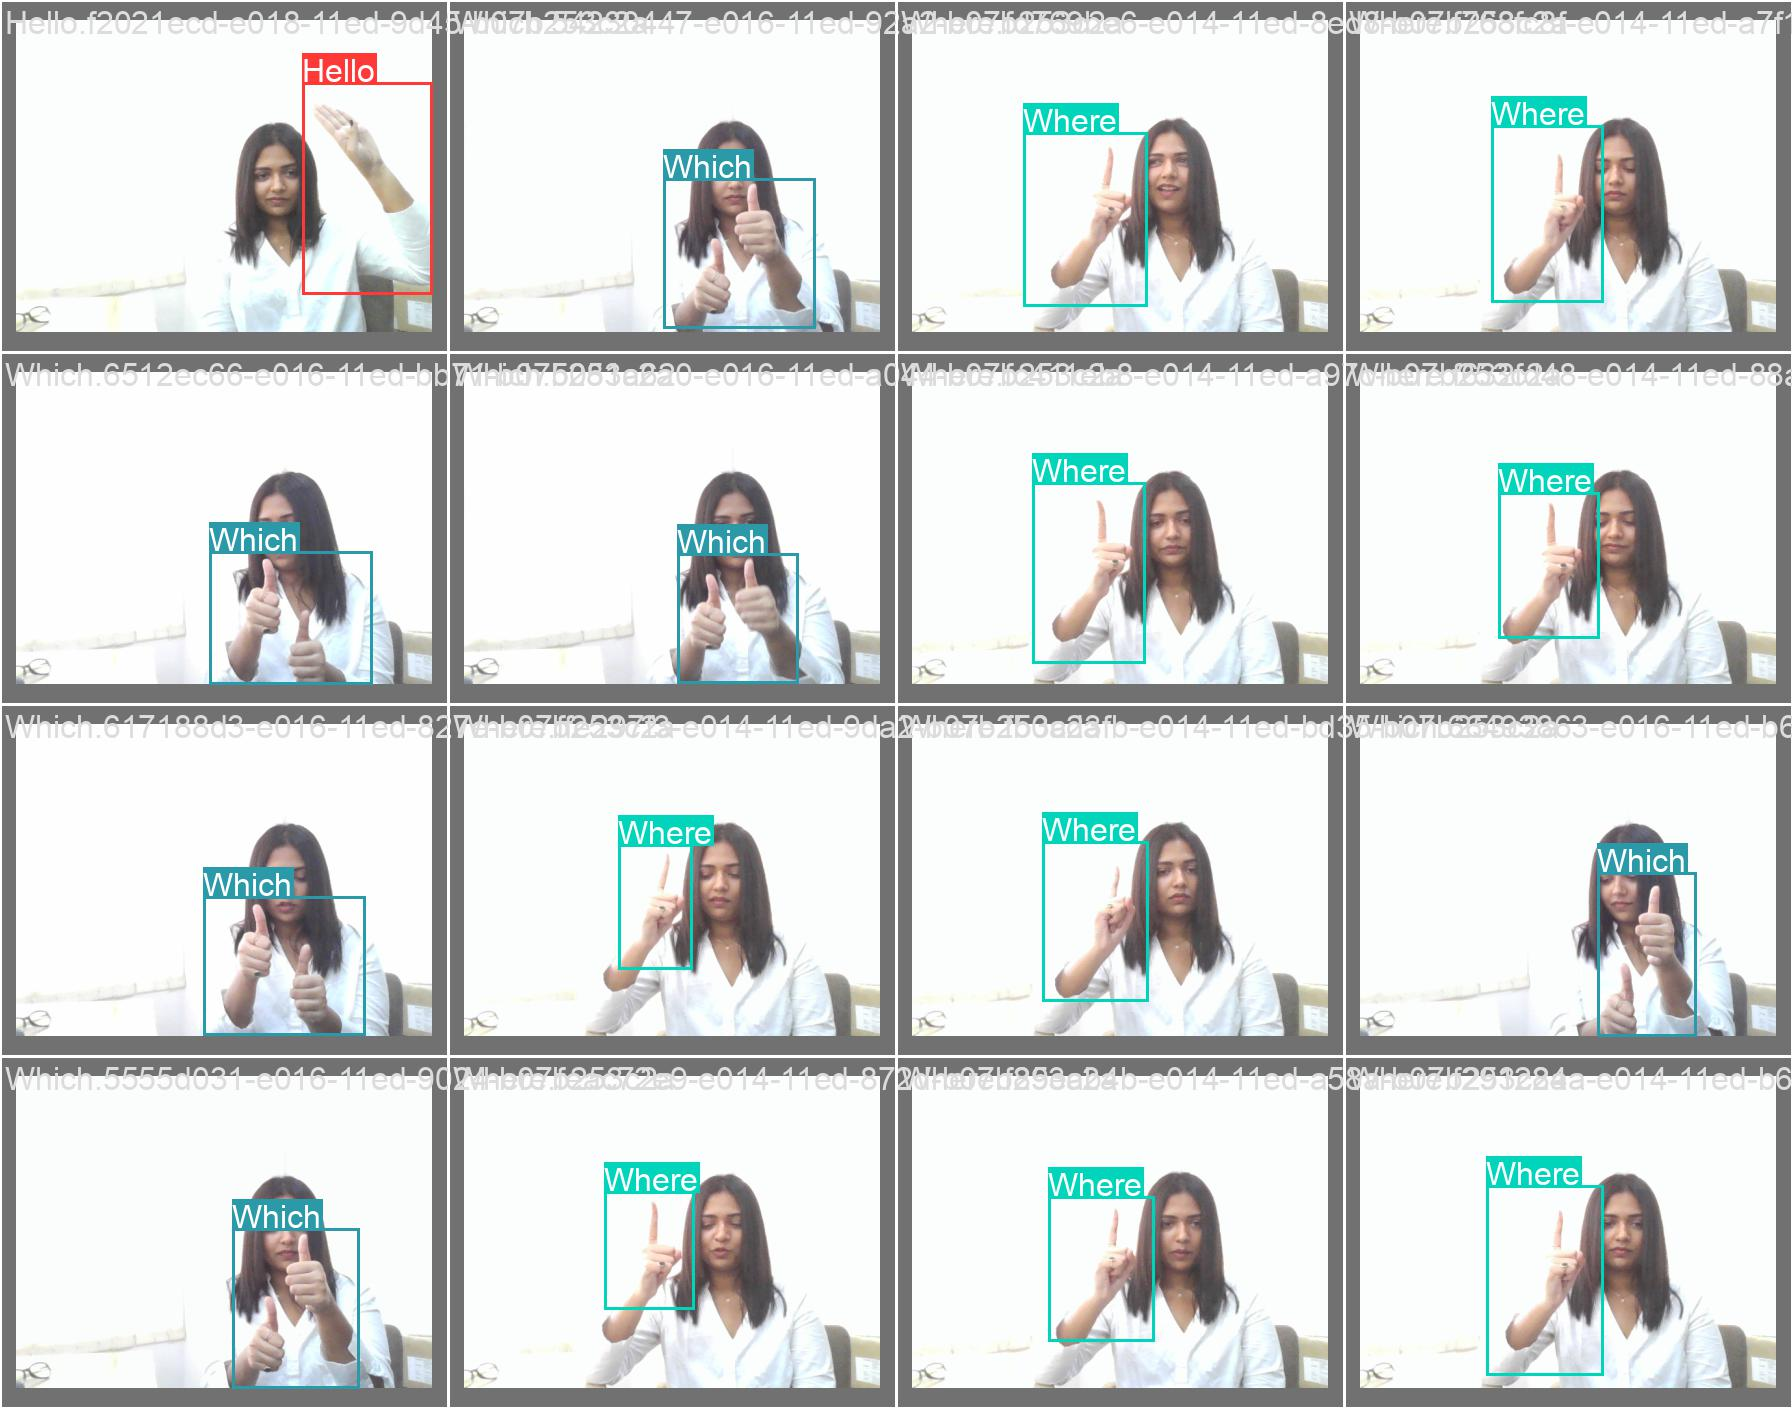

In [14]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


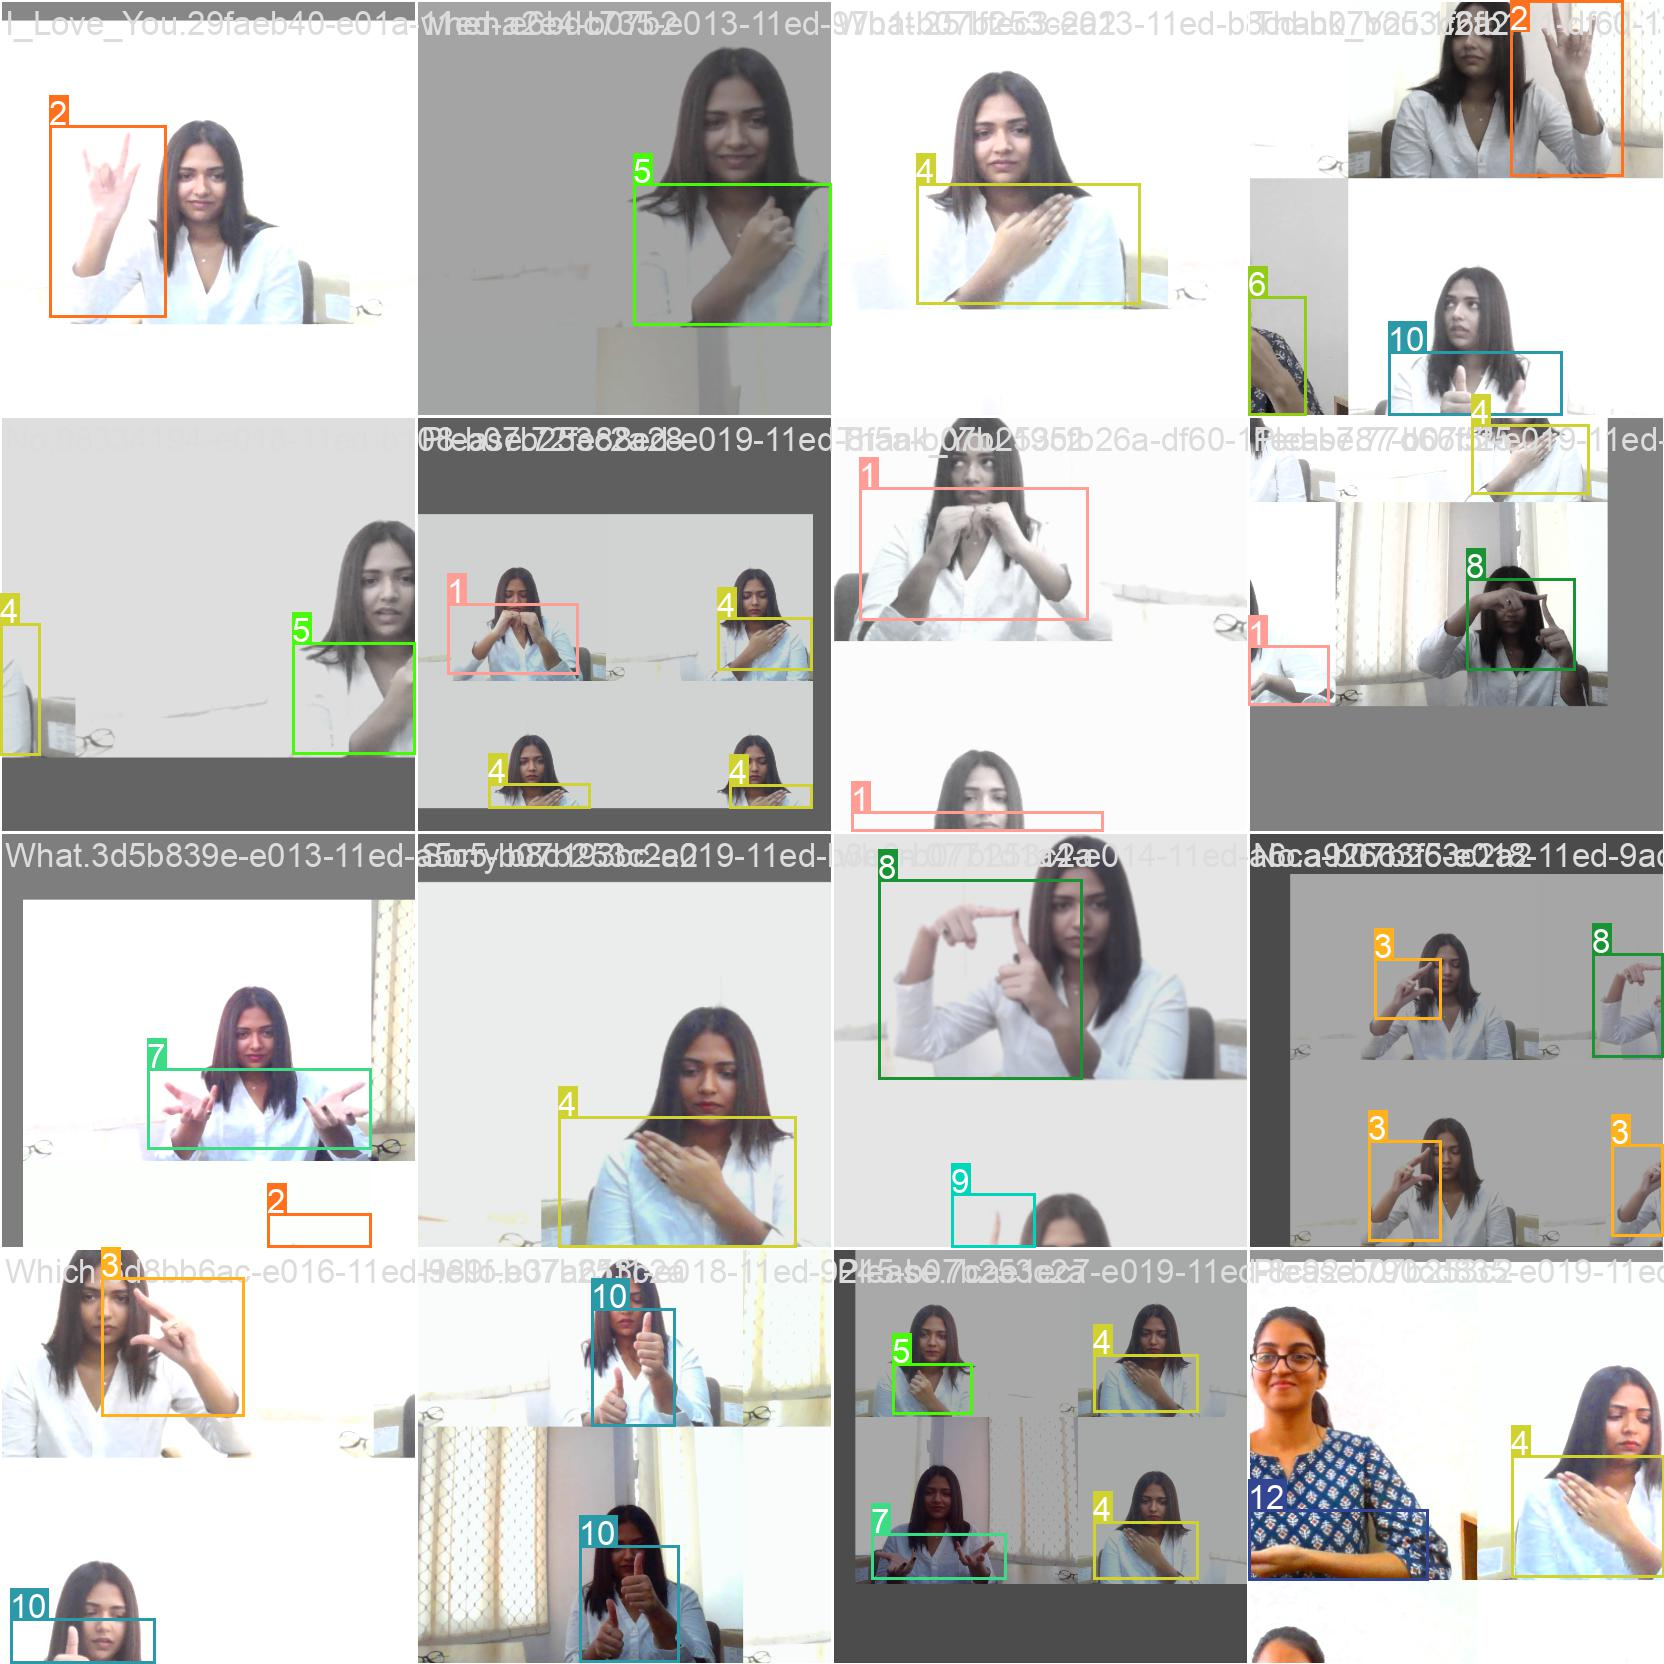

In [15]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [16]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [17]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [18]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.1 --source ../test/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=../test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /usr/local/lib/python3.10/dist-packages/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-168-gec2b853 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7278882 parameters, 0 gradients
image 1/130 /content/test/images/Hello.f2021ecd-e018-11ed-9d45-b07b253c2a28.jpg: 320x416 1 Hello, 63.7ms
image 2/130 /content/test/images/Hello.f33811d6-e018-11ed-b0d5-b07b253c2a28.jpg: 320x416 1 Hello, 8.5ms
image 3/130 /content/te

In [19]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

## Download the model!



In [20]:
#Download and save the model
%cd /content 
!zip -r yolov5.zip ./

/content
  adding: .config/ (stored 0%)
  adding: .config/config_sentinel (stored 0%)
  adding: .config/gce (stored 0%)
  adding: .config/configurations/ (stored 0%)
  adding: .config/configurations/config_default (deflated 15%)
  adding: .config/.last_survey_prompt.yaml (stored 0%)
  adding: .config/active_config (stored 0%)
  adding: .config/.last_update_check.json (deflated 22%)
  adding: .config/.last_opt_in_prompt.yaml (stored 0%)
  adding: .config/logs/ (stored 0%)
  adding: .config/logs/2023.05.15/ (stored 0%)
  adding: .config/logs/2023.05.15/13.34.29.729456.log (deflated 91%)
  adding: .config/logs/2023.05.15/13.35.57.028304.log (deflated 57%)
  adding: .config/logs/2023.05.15/13.35.21.121211.log (deflated 86%)
  adding: .config/logs/2023.05.15/13.35.29.575783.log (deflated 58%)
  adding: .config/logs/2023.05.15/13.35.56.261760.log (deflated 57%)
  adding: .config/logs/2023.05.15/13.34.55.186124.log (deflated 58%)
  adding: data.yaml (deflated 25%)
  adding: Sign_language_data